# 1. Подготовка

## 1.1 Фиксируем генераторы случайных чисел

In [1]:
# Для воспроизводимости результатов необходимо зафиксировать все генераторы случайных чисел.

import numpy as np
import pandas as pd
import random
import torch
import os

random.seed(97)
np.random.seed(97)
torch.manual_seed(97)
torch.cuda.manual_seed(97)
torch.backends.cudnn.deterministic = True

## 1.2 Задаем параметры обучения сети

In [2]:
# Расположение данных

# Путь к исходной обучающей выборке
PATH_TO_TRAIN = './input/plates/plates/train'
# Путь к аугментированной исходной обучающей выборке
PATH_TO_AUG = './input/plates/plates/aug'
# Путь к тестовой выборке
PATH_TO_TEST = './input/plates/plates/test'
# Путь к выборке, на которой будет обучаться модель
TRAIN_DIR = 'train'
# Путь к выборке, на которой будет оцениваться качество модели
VAL_DIR = 'val'
# Путь к тестовой выборки
TEST_DIR = 'test'

In [3]:
# Имена классов

labels = ['cleaned', 'dirty']

Параметры обучения

In [4]:
# использовать аугментации, порождаемые блокнотом augmentations
use_custom_augmentations = True

# Кол-во примеров из обучающей выборки, после которых делается градиентный шаг
batch_size = 16

# Скорость обучения нейронной сети
lr = 3e-4

# Штраф L2 регуляризации
l2_regularization = 5e-2
# Использовать l2 регуляризацию
l2_enabled = True

# Использовать Dropout
dropout_enabled = False
# шанс, что выход будет занулён
dropout_p = 0.1

# Кол-во эпох обучения
num_epoch = 70

# Если выход сети больше этого значения, то считаем тарелку грязной
dirty_split = 0.5

# каждое valid_split изображение обучающей выборки будет отложено для валидаионной выборки
valid_split = 50

Параметры lr_scheduler.StepLR

In [5]:
# Кол-во эпох, после которого уменьшается lerning rate
step_size = 20
gamma=0.2
# использовать планировщик
use_scheduler = True

In [6]:
# вывод прогресса обучения
show_progress = True
# вывод изображений для обучения
show_input = True
# количество батчей, которое нужно вывести перед обучением
batchs_to_show = 1

## 1.3 Изучаем исходные данные

In [7]:
from PIL import Image
from random import sample
from os.path import join
from os import listdir
import matplotlib.pyplot as plt

cleaned


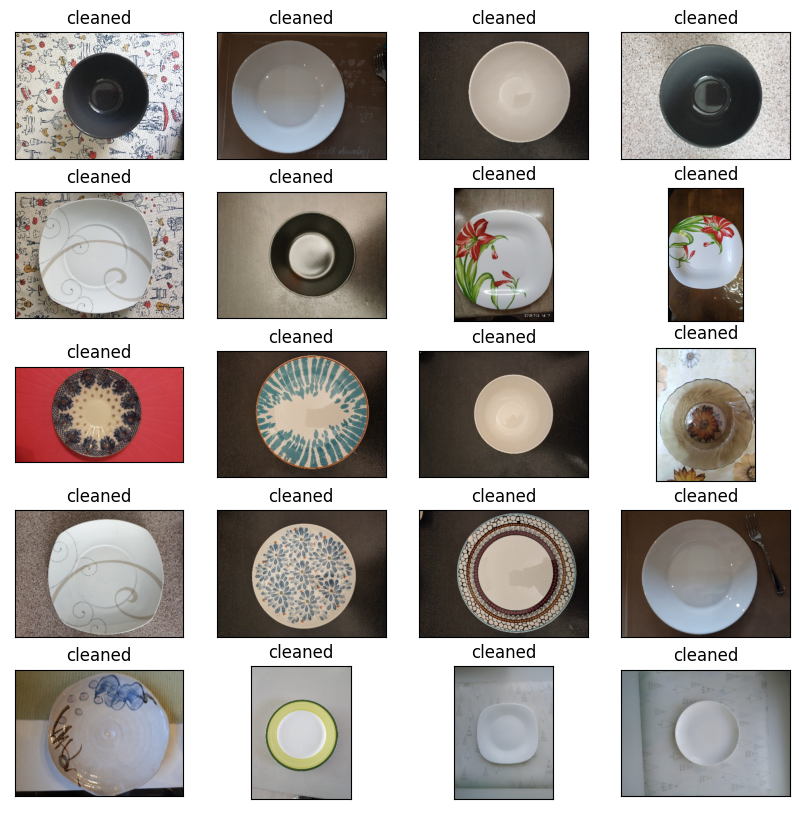

dirty


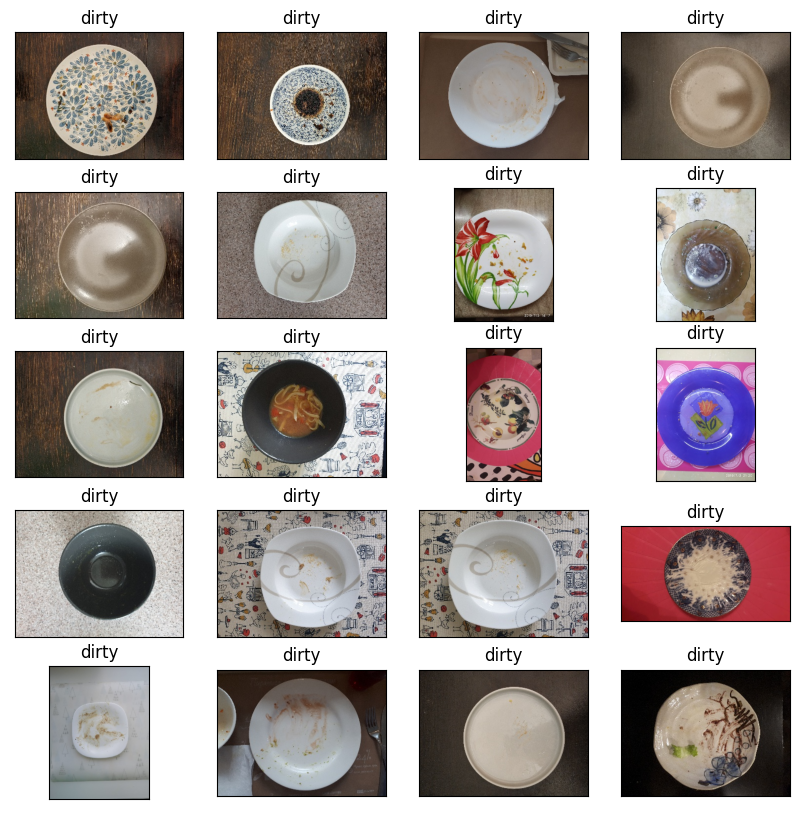

In [8]:
# Визуализация обучающей выборки

if show_input:
    for label in labels:
        print(label)
        # Путь к обучающим данным класса label
        PATH = join(PATH_TO_TRAIN, label)
        # Кол-во изображений в данной папке
        n = len(listdir(PATH))
        plt.figure(figsize=(10, 10))
        for i,image in enumerate(listdir(PATH)):
            plt.subplot(int(n/4), 4, i+1)
            img = Image.open(join(PATH,image))
            plt.imshow(img)
            plt.title(label)
            plt.xticks([])
            plt.yticks([])
        plt.show()

Test set


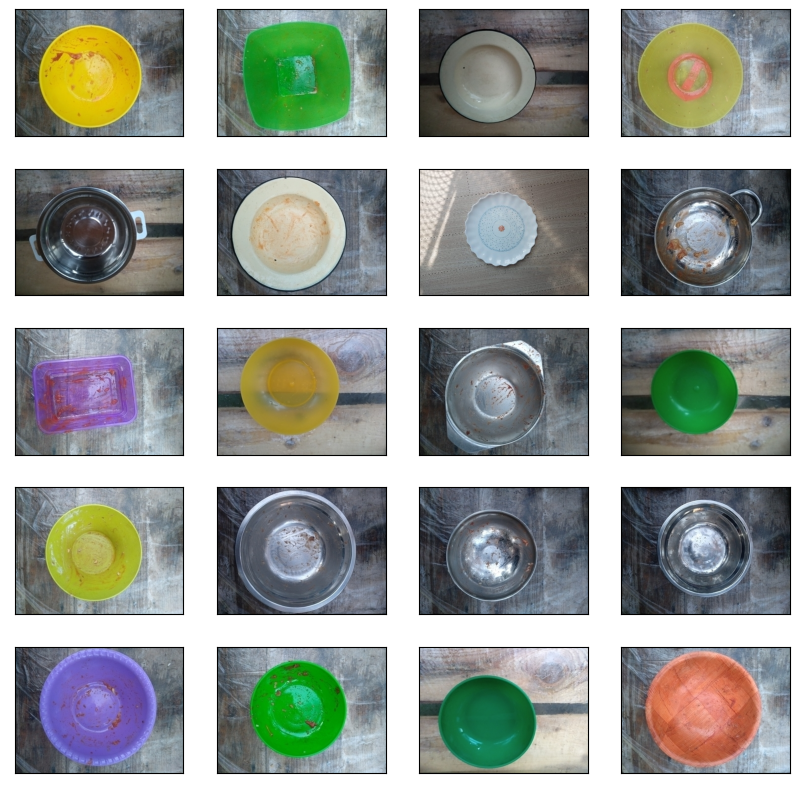

In [9]:
# Визуализация части тестовой выборки

if show_input:
    n_samples = 20
    # Выбираем случайные 20 изображенй из тестовой выборки
    sub_sample = sample(listdir(PATH_TO_TEST), n_samples)
    plt.figure(figsize=(10, 10))
    print('Test set')
    for i,image in enumerate(sub_sample):
        plt.subplot(int(n_samples/4), 4, i+1)
        img = Image.open(join(PATH_TO_TEST, image))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

## 1.4 Подготовка данных. Разделение на обучающую и валидационную выборку

In [10]:
from shutil import copy
from os import makedirs

In [11]:
# Разделим исходную обучающую выборку на обучающаю и валидационную. Для этого создадим папки train и val и в 
# каждой из них создадим папки cleaned и dirty.

for dir_name in [TRAIN_DIR, VAL_DIR]:
    for label in labels:
        makedirs(join(dir_name, label),
                exist_ok=True)

In [12]:
# Будем класть каждое valid_split по счету изображение из исходной обучающей выборки в валидационную выборку (в папку val), 
# остальные изображения будут скопированны в папку train. В случае своих дополнительных аугментаций, возьмём часть изображений 
# из path-to-train, запомним, остальные возьмём из path-to-aug

if not use_custom_augmentations:
    for label in labels:

        # Папка из которой будем копировать файлы 
        source_dir = join(PATH_TO_TRAIN, label)

        for i, file_name in enumerate(listdir(source_dir)):

            # Выбираем куда скопировать файл
            if i % valid_split != 0:
                dest_dir = join(TRAIN_DIR, label)
            else:
                dest_dir = join(VAL_DIR, label)

            # Копируем файл в выбранную папку
            copy(
                join(source_dir, file_name),
                join(dest_dir, file_name)
            )
else:
    for label in labels:
        # нужен для запоминания использованных имён
        validation_set = set()
        validation_source_dir = join(PATH_TO_TRAIN, label)
        
        for index, file_name in enumerate(listdir(validation_source_dir)):
            if index % valid_split == 0:
                dest_dir = join(VAL_DIR, label)
                copy(
                    join(validation_source_dir, file_name),
                    join(dest_dir, file_name)
                )
                validation_set.add(file_name[:4])
                
        train_source_dir = join(PATH_TO_AUG, label)
        
        for index, file_name in enumerate(listdir(train_source_dir)):
            if file_name[:4] not in validation_set:
                dest_dir = join(TRAIN_DIR, label)
                copy(
                    join(train_source_dir, file_name),
                    join(dest_dir, file_name)
                )

## 1.5. Аугментация данных

In [13]:
from torchvision import transforms

In [14]:
# Задаем последовательность преобразований изображений для увеличения разнообразия изображений.

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter()
    ]),
    transforms.RandomApply([
        transforms.RandomGrayscale()
    ]),
#     transforms.RandomRotation(30),
    transforms.RandomChoice([
#         transforms.Compose([
#             transforms.CenterCrop(224)
#         ]),
        transforms.Compose([
            transforms.RandomResizedCrop(224)
        ]) #,
#         transforms.Compose([
#             transforms.RandomPerspective(),
#             transforms.Resize((224, 224))
#         ]),
    ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                          [0.229, 0.224, 0.225])
])

## 1.6 Создание "загрузчиков данных" для обучения и валидации

In [15]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset

In [16]:
# Формирует датасет из избражений лежащих в указанной папке
train_dataset = ImageFolder(TRAIN_DIR, train_transforms)
val_dataset = ImageFolder(VAL_DIR, val_transforms)

In [17]:
# Загружает данные из сформированных ранее датасетов
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=batch_size)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=batch_size)

## 1.7 Визуализация обучающей выборки

In [18]:
def show_batch(X_batch, y_batch, batch_size):
    plt.figure(figsize=(10, 5))
    for i, (image_tensor, class_index) in enumerate(zip(X_batch, y_batch)):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image_tensor.permute(1, 2, 0).numpy()
        image = std * image + mean
        plt.subplot(int(batch_size/4), 4, i+1)
        plt.imshow(image)
        plt.title(labels[class_index])
        plt.xticks([])
        plt.yticks([])      
    plt.show()

Batch 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


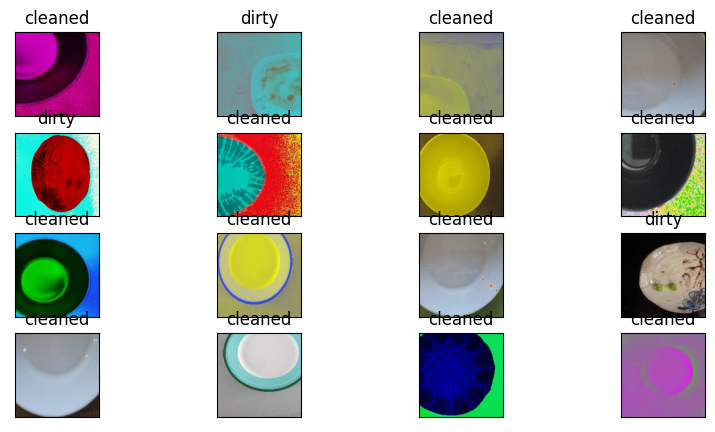

In [19]:
if show_input:
    for i in range(batchs_to_show):
        print('Batch', i+1)
        X_batch, y_batch = next(iter(train_dataloader))
        show_batch(X_batch, y_batch, batch_size)

# 2. Создание нейронной сети

## 2.1. Загрузка базовой модели

In [20]:
# для подсчёта средней скорости обучения
from time import time
from math import trunc

from torchvision import models
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler

In [22]:
class PlatesNet(torch.nn.Module):
    def __init__(self):
        super(PlatesNet, self).__init__()
        self.resnet = models.resnet152(pretrained=True, progress=False)

        # Замораживаем все слои
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
        
        # меняем последний слой предобученного resneta на свой (свои)
        in_features = self.resnet.fc.in_features
        if dropout_enabled:
            self.resnet.fc = torch.nn.Dropout(p=dropout_p)
            self.final_layer = torch.nn.Linear(in_features, 2)
        else:
            self.resnet.fc = torch.nn.Linear(in_features, 2)
    
    def forward(self, X):
        X = self.resnet(X)
        
        if dropout_enabled:
            X = self.final_layer(X)
        
        return X

model = PlatesNet()

# Перекладываем вычисления на GPU
# в случае ее отсутствия на CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("move to {}".format("gpu" if torch.cuda.is_available() else "cpu"))

move to cpu


In [23]:
# Задаем функцию потерь
loss = CrossEntropyLoss()

In [24]:
# Задаем оптимизатор
if l2_enabled:
    optimizer = Adam(model.parameters(),
                     lr=lr, weight_decay=l2_regularization)
else:
    optimizer = Adam(model.parameters(),
                     lr=lr)

In [25]:
scheduler = lr_scheduler.StepLR(optimizer,
                                step_size=step_size,
                                gamma=gamma)

## 2.2. Дообучение нейронной сети

In [26]:
def train_model(model,
                loss,
                optimizer,
                scheduler,
                num_epochs):
    # время начала обучения
    start_training_time = time()
    
    # Будем записывать промежуточные результаты
    # для дальнейшей визуализации обучения
    train_accuracy_history = []
    train_loss_history = []
    val_accuracy_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        if show_progress == True:
            print()
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # На каждой эпохе будем сначала обучать сеть
        # затем проверять ее качество на валидационной выборке
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
        
            running_loss = 0
            running_acc = 0
            
            # Загружаем данные и
            # и обнуляем градиент
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # На фазе обучения делаем вычисляем ошибку 
                # на тестовой выборке и делаем градиентный шаг
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                running_loss += loss_value.data.cpu()
                running_acc += (preds_class == labels.data).float().mean().data.cpu()
            
            # Средня ошибка и точность на эпохе
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
        
            # Запоминаем значения ошибки и точности 
            # для дальнейшей визуализации
            if phase == 'train':
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            
            if show_progress == True:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    
        if show_progress == True:
            speed = (epoch + 1) / (time() - start_training_time)
            time_in_seconds = trunc((num_epochs - epoch) / speed)
            print('Speed: {} epoch / s'.format(speed))
            print('Time remaining {} m {} s'.format(time_in_seconds // 60, time_in_seconds % 60))
            
    return train_accuracy_history, train_loss_history, val_accuracy_history, val_loss_history

In [27]:
history = train_model(model,
                      loss,
                      optimizer,
                      scheduler,
                      num_epochs=num_epoch);


Epoch 0/69:


C:\Users\Vu Ba Sang\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.3973 Acc: 0.8073
val Loss: 0.5023 Acc: 0.5000
Speed: 0.015806761103372303 epoch / s
Time remaining 73 m 48 s

Epoch 1/69:
train Loss: 0.1454 Acc: 0.9531
val Loss: 2.4146 Acc: 0.5000
Speed: 0.01600064522865567 epoch / s
Time remaining 71 m 52 s

Epoch 2/69:
train Loss: 0.1914 Acc: 0.9210
val Loss: 1.4676 Acc: 0.5000
Speed: 0.01607814118664496 epoch / s
Time remaining 70 m 29 s

Epoch 3/69:
train Loss: 0.2197 Acc: 0.9227
val Loss: 0.7391 Acc: 0.5000
Speed: 0.016040876518619265 epoch / s
Time remaining 69 m 36 s

Epoch 4/69:
train Loss: 0.1369 Acc: 0.9444
val Loss: 1.0908 Acc: 0.5000
Speed: 0.015942384600083643 epoch / s
Time remaining 68 m 59 s

Epoch 5/69:
train Loss: 0.2112 Acc: 0.9184
val Loss: 0.4986 Acc: 0.5000
Speed: 0.015665804565589827 epoch / s
Time remaining 69 m 9 s

Epoch 6/69:
train Loss: 0.1976 Acc: 0.9167
val Loss: 0.2687 Acc: 1.0000
Speed: 0.015623945639374638 epoch / s
Time remaining 68 m 16 s

Epoch 7/69:
train Loss: 0.1918 Acc: 0.9271
val Loss: 1.8215 Acc

val Loss: 1.3598 Acc: 0.5000
Speed: 0.015828715069518415 epoch / s
Time remaining 10 m 31 s

Epoch 61/69:
train Loss: 0.0374 Acc: 0.9870
val Loss: 1.3069 Acc: 0.5000
Speed: 0.01582596967938753 epoch / s
Time remaining 9 m 28 s

Epoch 62/69:
train Loss: 0.0248 Acc: 0.9922
val Loss: 1.2057 Acc: 0.0000
Speed: 0.015819076628135007 epoch / s
Time remaining 8 m 25 s

Epoch 63/69:
train Loss: 0.0291 Acc: 0.9896
val Loss: 1.2436 Acc: 0.0000
Speed: 0.015792644589151156 epoch / s
Time remaining 7 m 23 s

Epoch 64/69:
train Loss: 0.0255 Acc: 0.9896
val Loss: 1.2380 Acc: 0.5000
Speed: 0.015782490021670082 epoch / s
Time remaining 6 m 20 s

Epoch 65/69:
train Loss: 0.0368 Acc: 0.9896
val Loss: 1.4894 Acc: 0.5000
Speed: 0.015772953003772627 epoch / s
Time remaining 5 m 16 s

Epoch 66/69:
train Loss: 0.0559 Acc: 0.9835
val Loss: 1.5388 Acc: 0.5000
Speed: 0.01575800110261026 epoch / s
Time remaining 4 m 13 s

Epoch 67/69:
train Loss: 0.0404 Acc: 0.9896
val Loss: 1.3146 Acc: 0.5000
Speed: 0.01575576572

# 3. Визуализация обучения

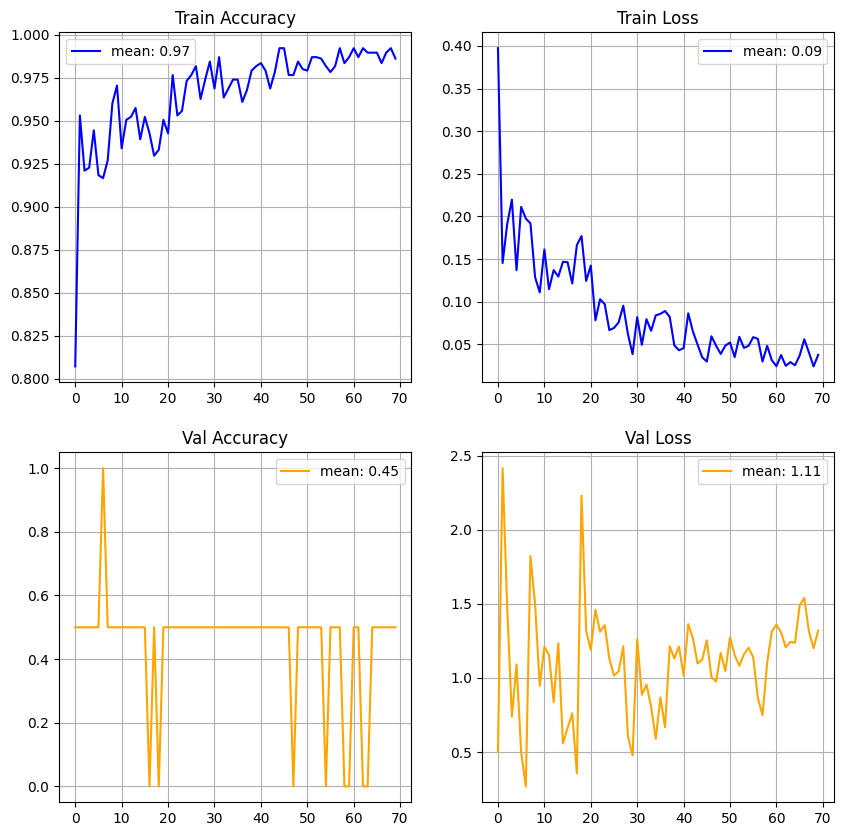

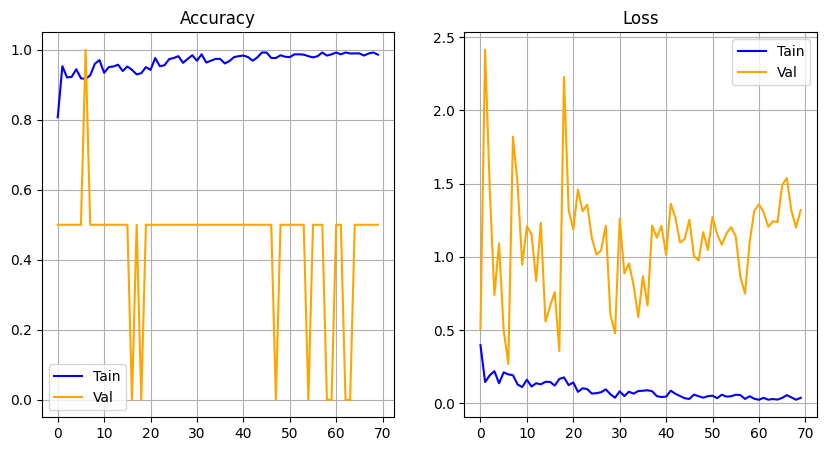

In [28]:
# Рисуем графики  Accuracy и Loss для Тренеровочной и валидационной выборки
titles = ['Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss']
plt.figure(figsize=(10, 10))
for i, image in enumerate(history):
    plt.subplot(2, 2, i+1)
    plt.title(titles[i])
    plt.grid()
    if i == 0 or i == 1:
        color = 'b'
    else:
        color = 'orange'
    plt.plot(image,c=color, label= 'mean: %.2f' % np.array(image).mean())
    plt.legend(loc='best')
plt.show()

# Рисуем совмещенные графики  Accuracy и Loss для Тренеровочной и валидационной выборки
titles_ = ['Accuracy','Loss']
plt.figure(figsize=(10, 5))
k=0
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(history[0+k], label='Tain', c='b')
    plt.plot(history[2+k], label='Val', c='orange')
    plt.title(titles_[i])
    plt.grid()
    plt.legend(loc='best')
    k += 1

In [29]:
from torch import nn

C:\Users\Vu Ba Sang\AppData\Local\Temp\ipykernel_15844\3038583282.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  labels[predict[i]],


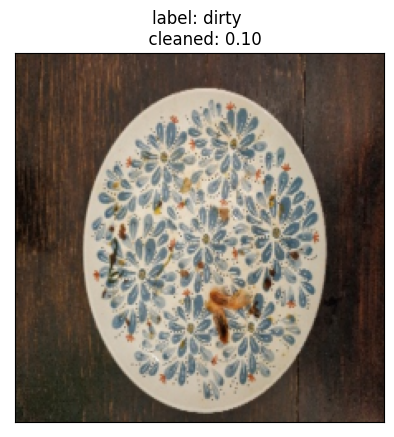

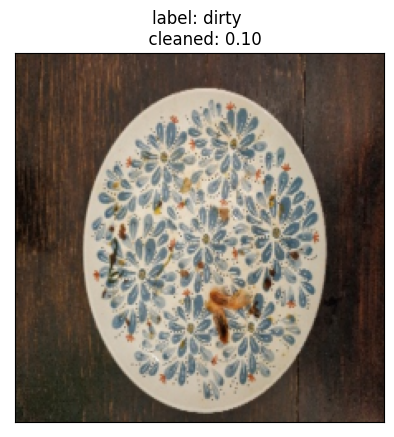

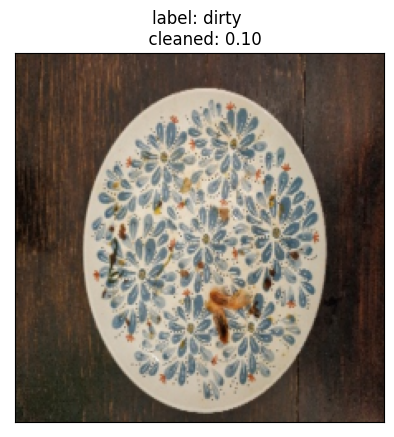

In [30]:
model.eval()

for _ in range(3):
    for inputs, labels_ in val_dataloader:
        inputs = inputs.to(device)
        labels_ = labels_.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        val_predictions = nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
        labels_ = labels_.cpu().numpy()
        predict = val_predictions > dirty_split
        ind = (labels_ == predict)
        for i, image_tensor in enumerate(inputs):
            if ind[i] == False:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = image_tensor.cpu().permute(1, 2, 0).numpy()
                image = std * image + mean
                plt.imshow(image)
                plt.title('label: %s \n  %s: %.2f' % (labels[labels_[i]],
                                                      labels[predict[i]],
                                                      val_predictions[i]))
                                                                   
                plt.xticks([])
                plt.yticks([]) 
                plt.show()
        print()

# 4. Классификация тестовой выборки

In [31]:
from shutil import copytree

In [32]:
# Копируем тестовые изображения 
# в папку 'test/unknown'
# для правильной работы ImageFolder
copytree(PATH_TO_TEST,
         join(TEST_DIR, 'unknown'))

'test\\unknown'

In [33]:
from torchvision import transforms, models, datasets

In [34]:
# Модифицируем ImageFolder так, что бы он 
# отображал не только изображение с его меткой, но и
# путь к изображению
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths,self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [57]:
test_dataset = ImageFolderWithPaths(TEST_DIR, val_transforms)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=0)

In [58]:
# Переведем модель в evaluation состояние
# (не будут изменятся параметры сети)
model.eval()

# Предсказания
test_predictions = []
# Пути к изображениям
test_img_paths = []

In [59]:
type(DataLoader)

type

In [60]:
from tqdm import tqdm
# В цикле полусаем Batch с изображениями, метку класса ('unknown') и пути к изображениям
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        # Считаем предсказания модели
        preds = model(inputs)
    # С помощью softmax приводим их к вероятностям
    # В результате получаем вероятность первого класса ('грязная тарелка')
    test_predictions.append(nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    # Пути нужны для визуализации и созранения предсказаний
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:18<00:00,  2.94s/it]


## 4.1. Визуализация предсказаний

In [61]:
prediction = dict(zip(test_img_paths, test_predictions))

Test set


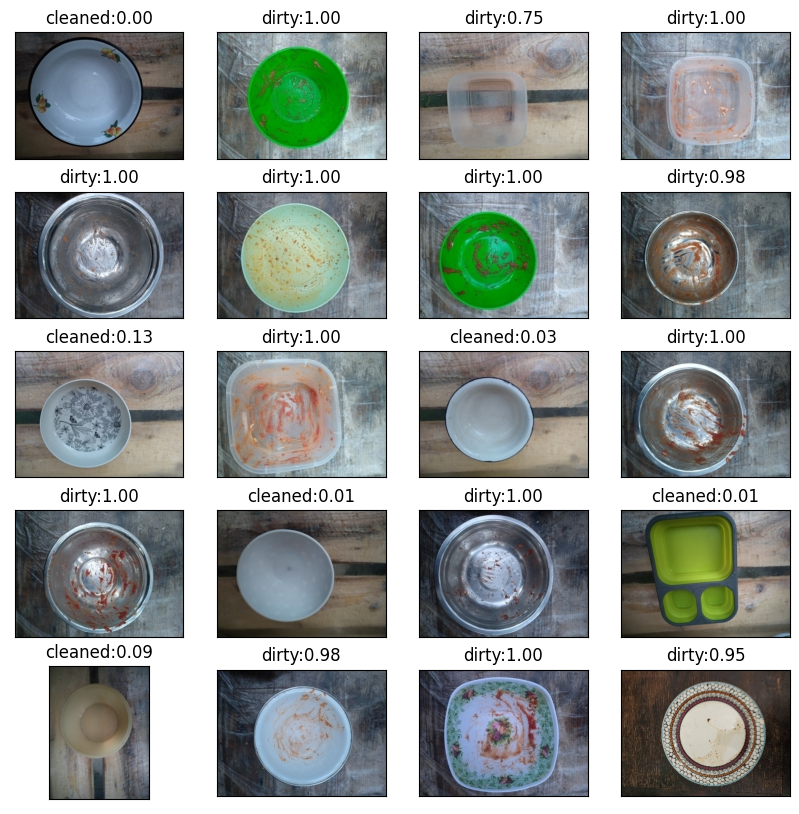

In [63]:
# Визуализация предсказаний классификатора
n_samples = 20
sub_sample = sample(test_img_paths, n_samples)
plt.figure(figsize=(10, 10))
print('Test set')
for i,image in enumerate(sub_sample):
    plt.subplot(int(n_samples/4), 4, i+1)
    img = Image.open(image)
    plt.imshow(img)
    title = 'dirty' if prediction[image] > dirty_split else 'cleaned'
    title = '%s:%.2f' % (title, prediction[image])
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
plt.show()

# 5. Сохранение предсказаний

In [221]:
# Формируем DataFrame из путей к изображениям и соответствующим им предсказанным классам
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 
                                        'label': test_predictions})

In [222]:
submission_df.head()

id     label
0  test\unknown\0000.jpg  0.999999
1  test\unknown\0001.jpg  0.999927
2  test\unknown\0002.jpg  0.951089
3  test\unknown\0003.jpg  0.998996
4  test\unknown\0004.jpg  0.724240

In [223]:
submission_df

id     label
0    test\unknown\0000.jpg  0.999999
1    test\unknown\0001.jpg  0.999927
2    test\unknown\0002.jpg  0.951089
3    test\unknown\0003.jpg  0.998996
4    test\unknown\0004.jpg  0.724240
..                     ...       ...
739  test\unknown\0739.jpg  0.612733
740  test\unknown\0740.jpg  0.999555
741  test\unknown\0741.jpg  0.023359
742  test\unknown\0742.jpg  0.987575
743  test\unknown\0743.jpg  0.005809

[744 rows x 2 columns]

In [224]:
submission_df['id']

0      test\unknown\0000.jpg
1      test\unknown\0001.jpg
2      test\unknown\0002.jpg
3      test\unknown\0003.jpg
4      test\unknown\0004.jpg
               ...          
739    test\unknown\0739.jpg
740    test\unknown\0740.jpg
741    test\unknown\0741.jpg
742    test\unknown\0742.jpg
743    test\unknown\0743.jpg
Name: id, Length: 744, dtype: object

In [225]:
len(submission_df)

744

In [226]:
# Отчищаем id от лишего, оставляя только номер изображения
# И преобразуем вероятности к классам
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > dirty_split else 'cleaned')
# submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
for i in range(len(submission_df)):
    submission_df['id'][i] = submission_df['id'][i][13:]
submission_df.set_index('id', inplace=True)
submission_df.head()

C:\Users\Vu Ba Sang\AppData\Local\Temp\ipykernel_15844\3651134582.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


label
id         
0000  dirty
0001  dirty
0002  dirty
0003  dirty
0004  dirty

In [227]:
# Сохраняем в csv файл
submission_df.to_csv('submission.csv')

# Удаляем созданные файлы

In [ ]:
!rm -rf train val test